In [1]:
import numpy as np
import scipy as sp
from scipy.optimize import minimize_scalar, minimize
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def eqn_sp(alpha):

    def gaussian(z, mean=0, var=1):
        return np.exp(-0.5 * (z - mean) ** 2 / var) / np.sqrt(2 * np.pi * var)

    def f_z(z, *args):
        y, xi, chi = args
        return float(y != np.sign(z)) + (z - xi) ** 2 / (2 * chi + 1e-8)

    def extr(chi):
        term1 = -1 / (2 * chi + 1e-8)
        term2 = alpha * 0.5 * (
            sp.integrate.quad(
                lambda xi: gaussian(xi) * minimize_scalar(f_z, args=(1, xi, chi)).fun,
                a=-np.inf, b=np.inf
            )[0]
            + sp.integrate.quad(
                lambda xi: gaussian(xi) * minimize_scalar(f_z, args=(-1, xi, chi)).fun,
                a=-np.inf, b=np.inf
            )[0]
        )
        e_gs = term1 + term2
        return e_gs
    
    res = minimize_scalar(lambda chi: -extr(chi))
    return 1 - 2 / alpha * (-res.fun)

In [3]:
alphas = np.linspace(1e-3, 20, 50)
res = [eqn_sp(a) for a in tqdm(alphas)]

100%|██████████| 50/50 [13:21<00:00, 16.02s/it]


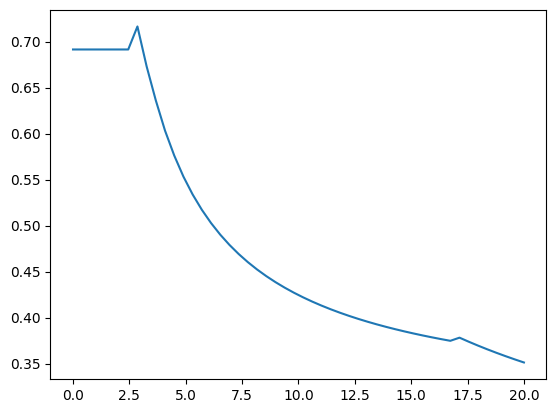

In [4]:
plt.plot(alphas, res)

In [5]:
def eqn_sp_rsb(alpha):

    def gaussian(z, mean=0, var=1):
        return np.exp(-0.5 * (z - mean) ** 2 / var) / np.sqrt(2 * np.pi * var)

    def f_z(z, *args):
        y, xi_0, xi_1, chi, q_0 = args
        return float(y != np.sign(z)) + (z - np.sqrt(q_0) * xi_0 - np.sqrt(1 - q_0) * xi_1) ** 2 / (2 * chi + 1e-8)

    def extr(x):
        chi, omega_0, q_0 = x

        term1 = 1/(2 * omega_0 * chi + 1e-8) * np.log(1 + omega_0 * (1 - q_0))
        term2 = q_0 / (2 * chi * (1 + omega_0 * (1 - q_0)) + 1e-8)
        term3 = alpha / (chi * omega_0) * 0.5  * (
            sp.integrate.quad(
                lambda xi_0: gaussian(xi_0) * np.log(
                    sp.integrate.quad(
                        lambda xi_1: gaussian(xi_1) * np.exp(
                            -omega_0 * chi * minimize_scalar(f_z, args=(1, xi_0, xi_1, chi, q_0)).fun
                        ),
                        a=-10, b=10
                    )[0]
                ),
                a=-10, b=10
            )[0]
            + sp.integrate.quad(
                lambda xi_0: gaussian(xi_0) * np.log(
                    sp.integrate.quad(
                        lambda xi_1: gaussian(xi_1) * np.exp(
                            -omega_0 * chi * minimize_scalar(f_z, args=(-1, xi_0, xi_1, chi, q_0)).fun
                        ),
                        a=-10, b=10
                    )[0]
                ),
                a=-10, b=10
            )[0]
        )
        e_gs = term1 + term2 + term3
        return e_gs
    
    cons = (
        {"type": "ineq", "fun": lambda x: x[2]},
        {"type": "ineq", "fun": lambda x: 1 - x[2]},
    )
    res = minimize(lambda x: -extr(x), x0=[0.5, 0.5, 0.5], constraints=cons)
    return 1 - 2 / alpha * (-res.fun)